In [1]:
import bambi as bmb
import pandas as pd
import numpy as np
import pymc3 as pm
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

Here we will analyze a dataset from experimental psychology in which a sample of 36 human participants engaged in what is called the [shooter task](http://psych.colorado.edu/~jclab/FPST.html), yielding 3600 responses and reaction times (100 from each subject). The link above gives some more information about the shooter task, but basically it is a sort of crude first-person-shooter video game in which the subject plays the role of a police officer. The subject views a variety of urban scenes, and in each round or "trial" a person or "target" appears on the screen after some random interval. This person is either Black or White (with 50% probability), and they are holding some object that is either a gun or some other object like a phone or wallet (with 50% probability). When a target appears, the subject has a very brief response window -- 0.85 seconds in this particular experiment -- within which to press one of two keyboard buttons indicating a "shoot" or "don't shoot" response. Subjects receive points for correct and timely responses in each trial; subjects' scores are penalized for incorrect reponses (i.e., shooting an unarmed person or failing to shoot an armed person) or if they don't respond within the 0.85 response window. The goal of the task, from the subject's perspective, is to maximize their score.

The typical findings in the shooter task are that (a) subjects are quicker to respond to armed targets than to unarmed targets, but are *especially* quick toward armed black targets and especially slow toward unarmed black targets, and (b) subjects are more likely to shoot black targets than white targets, whether they are armed or not.

# Load and examine data

In [132]:
shooter = pd.read_csv('data/shooter.csv', na_values='.')
shooter.head(10)

,subject,target,trial,race,object,time,response
0,1,w05,19,white,nogun,658.0,correct
1,2,b07,19,black,gun,573.0,correct
2,3,w05,19,white,gun,369.0,correct
3,4,w07,19,white,gun,495.0,correct
4,5,w15,19,white,nogun,483.0,correct
5,6,w96,19,white,nogun,786.0,correct
6,7,w13,19,white,nogun,519.0,correct
7,8,w06,19,white,nogun,567.0,correct
8,9,b14,19,black,gun,672.0,incorrect
9,10,w90,19,white,gun,457.0,correct


The design of the experiment is such that the subject, target, and object (i.e., gun vs. no gun) factors are fully crossed: each subject views each target twice, once with a gun and once without a gun.

In [5]:
pd.crosstab(shooter['subject'], [shooter['target'], shooter['object']])

target  b01       b02       b03       b04       b05        ...  w95       w96  \
object  gun nogun gun nogun gun nogun gun nogun gun nogun  ...  gun nogun gun   
subject                                                    ...                  
1         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
2         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
3         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
4         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
5         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
6         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
7         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
8         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
9         1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
10        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
11        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
12        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
13        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
14        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
15        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
16        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
17        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
18        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
19        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
20        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
21        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
22        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
23        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
24        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
25        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
26        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
27        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
28        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
29        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
30        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
31        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
32        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
33        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
34        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
35        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   
36        1     1   1     1   1     1   1     1   1     1  ...    1     1   1   

target        w97       w98       w99        
object  nogun gun nogun gun nogun gun nogun  
subject                                      
1           1   1     1   1     1   1     1  
2           1   1     1   1     1   1     1  
3           1   1     1   1     1   1     1  
4           1   1     1   1     1   1     1  
5           1   1     1   1     1   1     1  
6           1   1     1   1     1   1     1  
7           1   1     1   1     1   1     1  
8           1   1     1   1     1   1     1  
9           1   1     1   1     1   1     1  
10          1   1     1   1     1   1     1  
11          1   1     1   1     1   1     1  
12          1   1     1   1     1   1     1  
13          1   1     1   1     1   1     1  
14          1   1     1   1     1   1     1  
15          1   1     1   1     1   1     1  
16          

The response speeds on each trial are recorded given as reaction times (milliseconds per response), but here we invert them to and multiply by 1000 so that we are analyzing response rates response rates (responses per second). There is no theoretical reason to prefer one of these metrics over the other, but it turns out that response rates tend to have nicer distributional properties than reaction times (i.e., deviate less strongly from the standard Gaussian assumptions), so response rates will be a little more convenient for us by allowing us to use some fairly standard distributional models.

In [3]:
shooter['rate'] = 1000.0/shooter['time']

(array([ 282.,  583.,  868.,  828.,  510.,  245.,  124.,   42.,   12.,    8.]),
 array([ 1.1778563 ,  1.34660362,  1.51535094,  1.68409826,  1.85284559,
         2.02159291,  2.19034023,  2.35908755,  2.52783487,  2.69658219,
         2.86532951]),
 <a list of 10 Patch objects>)

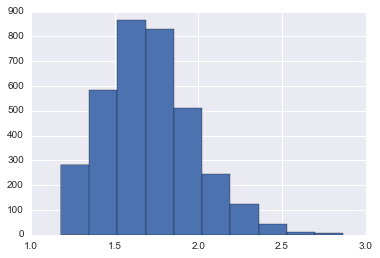

In [17]:
plt.hist(shooter['rate'].dropna())

# Fit response rate models

### Random subject effects only

Our first model is analogous to how the data from the shooter task are usually analyzed: incorporating all subject-level sources of variability, but ignoring the sampling variability due to the sample of 50 targets. This is a Bayesian generalized linear mixed model (GLMM) with a Normal response and with intercepts and slopes that vary randomly across subjects. Of note here is the `C(x, Sum)` syntax, which is from the [Patsy library](http://statsmodels.sourceforge.net/stable/contrasts.html) that we use to parse formulae. This instructs Bambi to use contrast codes of -1 and +1 for the two levels of each of the fixed factors of `race` (black vs. white) and `object` (gun vs. no gun), so that the `race` and `object` coefficients can be interpreted as simple effects on average across the levels of the other factor (directly analogous, but not quite equivalent, to the main effects). This is the standard coding used in ANOVA.

In [38]:
subj_model = bmb.Model(shooter, dropna=True)
subj_fitted = subj_model.fit('rate ~ C(race, Sum)*C(object, Sum)',
                             random=['C(race, Sum)*C(object, Sum)|subject'],
                             samples=1000, chains=4)

/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:271: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:142: UserWarning: 98 rows were found contain at least one missing value. Automatically removing 98 rows from the dataset.
  warnings.warn(msg)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -56.841: 100%|██████████| 50000/50000 [00:37<00:00, 1337.17it/s]   
Finished [100%]: Average ELBO = -56.773
INFO:pymc3:Finished [100%]: Average ELBO = -56.773
100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


First let's visualize the default priors that Bambi automatically decided on for each of the parameters. We do this by calling the `.plot()` method of the `Model` object.

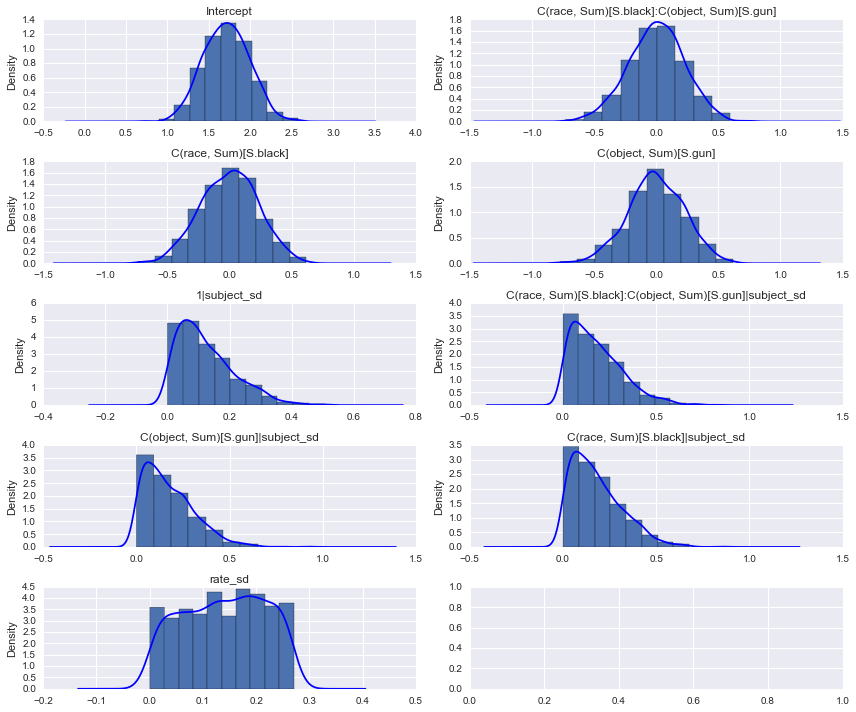

In [41]:
_ = subj_model.plot()

The priors on the fixed effects seem quite reasonable. Recall that because of the -1 vs +1 contrast coding, the coefficients correspond to *half* the difference betwen the two levels of each factor. So the priors on the fixed effects essentially say that the black vs. white and gun vs. no gun (and their interaction) response rate differences are very unlikely to be as large as a full response per second. The priors on the standard deviations of the random effects are yoked to the corresponding fixed effect priors (see [our technical paper](https://arxiv.org/abs/1702.01201) for more info).

Now let's visualize the model estimates. We do this by calling the `.plot()` method of the `MCMCResults` object that resulted from our call to `Model.fit()`.

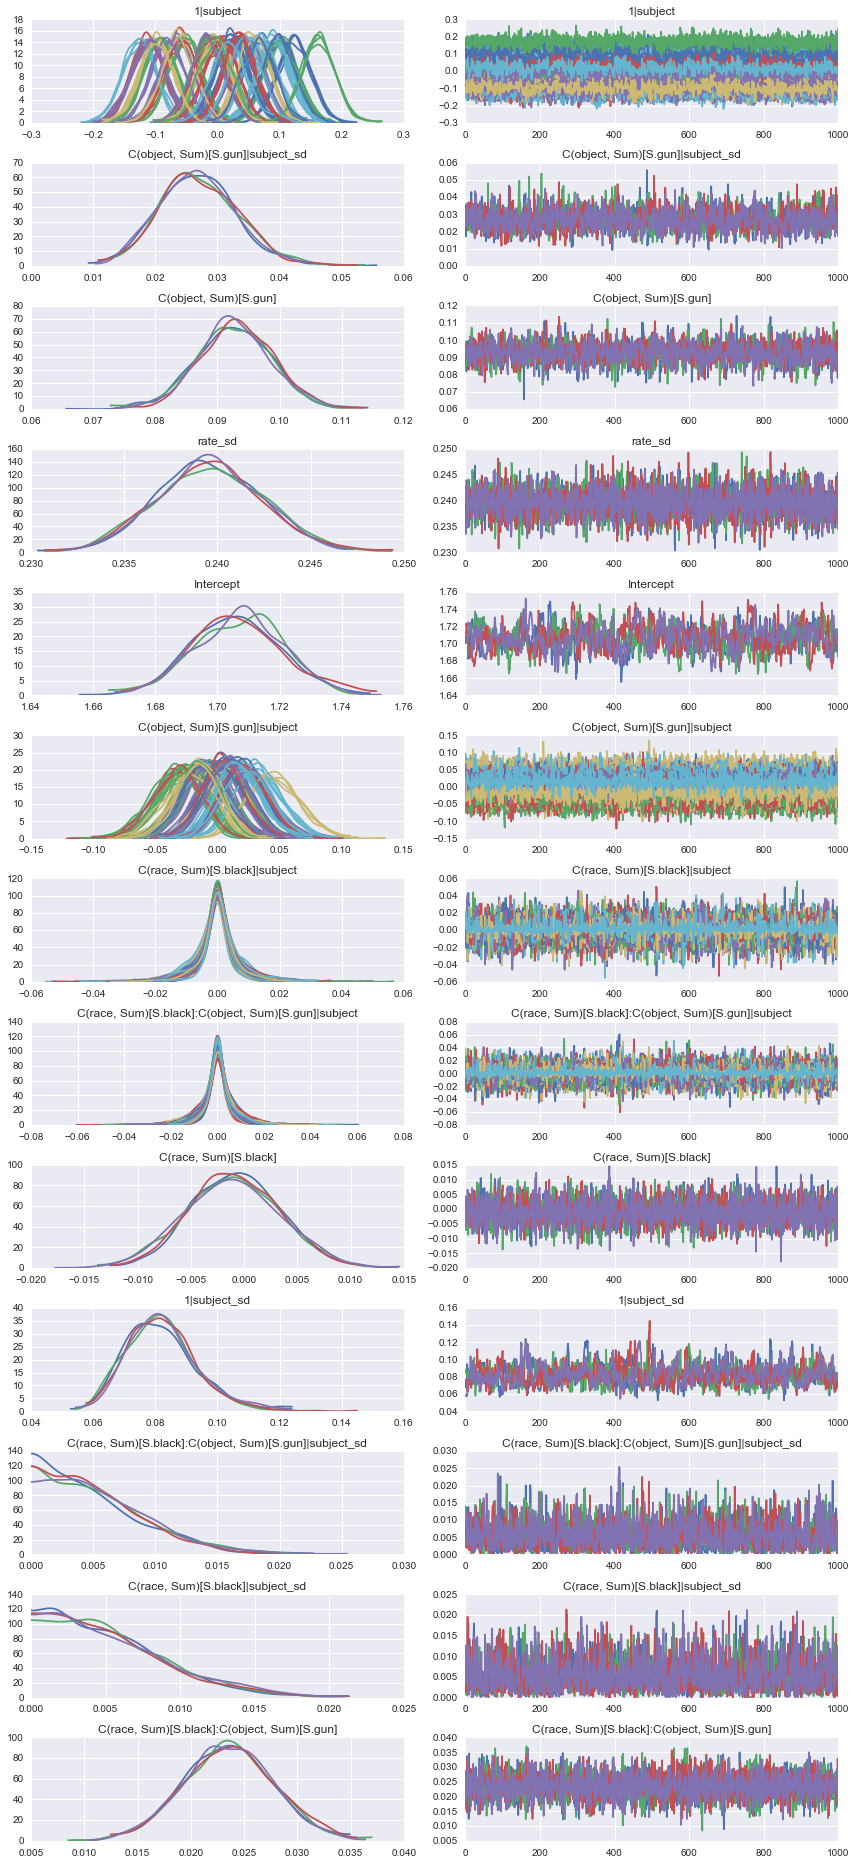

In [45]:
_ = subj_fitted.plot()

Each distribution in the plots above has 4 densities because we used 4 MCMC chains, so we are viewing the results of all 4 chains prior to their aggregation. The main message from the plot above is that the chains all seem to have converged well and the resulting posterior distributions all look quite reasonable. It's a bit easier to digest all this information in a concise, tabular form, which we can get by calling the `.summary()` method of the `MCMCResults` object.

In [40]:
subj_fitted.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
"C(object, Sum)[S.gun]|subject_sd",0.026916,0.006253,1.491781e-02,0.039202,1452,1.001191
"C(object, Sum)[S.gun]",0.092706,0.005984,8.164519e-02,0.104918,2178,1.001997
rate_sd,0.239562,0.002832,2.341165e-01,0.245169,4000,0.999613
Intercept,1.706634,0.014420,1.677821e+00,1.734589,383,1.000727
"C(race, Sum)[S.black]",-0.000984,0.004305,-9.394006e-03,0.007362,4000,1.000444
1|subject_sd,0.082052,0.011351,6.148593e-02,0.104953,676,1.000721
"C(race, Sum)[S.black]:C(object, Sum)[S.gun]|subject_sd",0.005429,0.004098,4.929724e-06,0.013424,2214,1.001934
"C(race, Sum)[S.black]|subject_sd",0.005366,0.003977,4.109750e-07,0.013184,2263,1.000167
"C(race, Sum)[S.black]:C(object, Sum)[S.gun]",0.023543,0.004202,1.524923e-02,0.031799,4000,1.000252


The take-home message from the analysis seems to be that we do find evidence for the usual finding that subjects are especially quick to respond (presumably with a shoot response) to armed black targets and especially slow to respond to unarmed black targets (while unarmed white targets receive "don't shoot" responses with less hesitation). We see this in the fact that the marginal posterior for the `C(race, Sum)[S.black]:C(object, Sum)[S.gun]` interaction coefficient is concentrated strongly away from 0. 

### Random stimulus effects

A major flaw in the analysis above is that random stimulus effects are ignored. The model does include random effects for subjects, reflecting the fact that the subjects we observed are but a sample from the broader population of subjects we are interested in and that potentially could have appeared in our study. But the targets we observed -- the 50 photographs of white and black men that subjets responded to -- are also but a sample from the broader theoretical population of targets we are interested in talking about, and that we could have just as easily and justifiably used as the experimental stimuli in the study. Since the stimuli comprise a random sample, they are subject to sampling variability, and this sampling variability should be accounted in the analysis by including random stimulus effects. For some more information on this, [see here, particularly pages 62-63](http://jakewestfall.org/publications/JWK.pdf).

To account for this, we let the intercept and `object` slope vary randomly across targets. Random object slopes across targets are possible because, if you recall, the design of the study was such that each target gets viewed twice by each subject, once with a gun and once without a gun. However, because each target is always either white or black, it's not possible to add random slopes for the `race` factor or the interaction.

In [4]:
stim_model = bmb.Model(shooter, dropna=True)
stim_fitted = stim_model.fit('rate ~ C(race, Sum)*C(object, Sum)',
                             random=['C(race, Sum)*C(object, Sum)|subject',
                                     'C(object, Sum)|target'],
                             samples=1000, chains=4)

/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:271: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:142: UserWarning: 98 rows were found contain at least one missing value. Automatically removing 98 rows from the dataset.
  warnings.warn(msg)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = 327.04: 100%|██████████| 50000/50000 [00:46<00:00, 1071.05it/s]    
Finished [100%]: Average ELBO = 327.77
INFO:pymc3:Finished [100%]: Average ELBO = 327.77
100%|██████████| 1000/1000 [01:51<00:00,  4.37it/s]


Now let's look at the results...

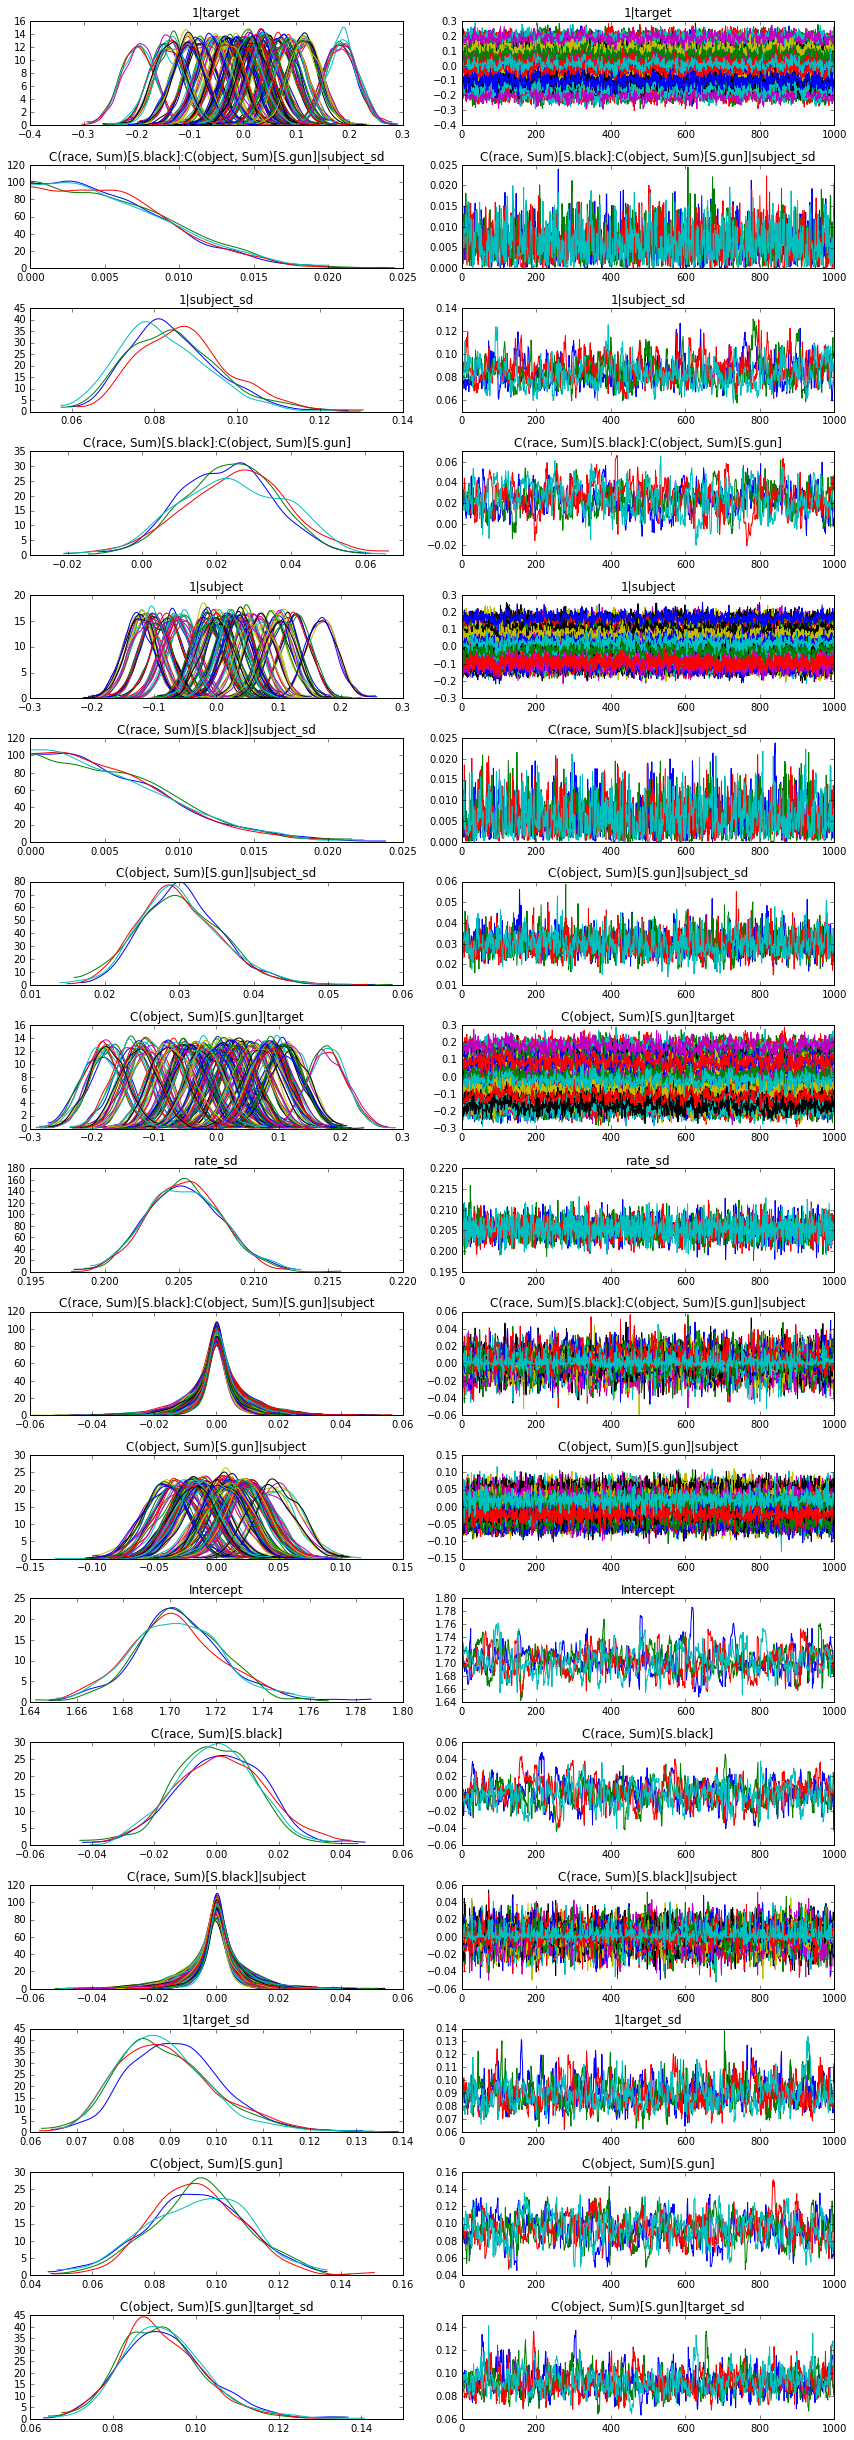

In [5]:
_ = stim_fitted.plot()

In [6]:
stim_fitted.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
"C(race, Sum)[S.black]:C(object, Sum)[S.gun]|subject_sd",0.005975,0.004184,0.000002,0.013933,2102,1.000360
1|subject_sd,0.084537,0.011197,0.063949,0.106820,298,1.017643
"C(race, Sum)[S.black]:C(object, Sum)[S.gun]",0.024013,0.013277,-0.001155,0.049820,436,1.002636
"C(race, Sum)[S.black]|subject_sd",0.005883,0.004292,0.000007,0.014249,1742,0.999922
"C(object, Sum)[S.gun]|subject_sd",0.030163,0.005574,0.019827,0.041660,1590,1.000541
rate_sd,0.205356,0.002477,0.200684,0.210381,4000,0.999647
Intercept,1.703503,0.019477,1.663271,1.740448,464,1.001764
"C(race, Sum)[S.black]",0.000227,0.013941,-0.030439,0.024776,459,1.003889
1|target_sd,0.089605,0.010246,0.071034,0.110202,569,1.006980
"C(object, Sum)[S.gun]",0.093756,0.015672,0.063165,0.124581,387,1.000347


There are two interesting things to note here. The first is that the key interaction effect, `C(race, Sum)[S.black]:C(object, Sum)[S.gun]` is much less clear now. The marginal posterior is still mostly concentrated away from 0, but there's certainly a nontrivial part that overlaps with 0; 3.2% of the distribution, to be exact. 

In [16]:
(stim_fitted['C(race, Sum):C(object, Sum)'].to_df() < 0).mean()

C(race, Sum)[S.black]:C(object, Sum)[S.gun]    0.032
dtype: float64

The second interesting thing is that the two new variance components in the model, those associated with the random stimulus effects, are actually rather large. This actually largely explains the first fact above, since if these where estimated to be close to 0 anyway, the model estimates wouldn't be much different than they were in the `subj_model`. It makes sense that there is a strong tendency for different targets to elicit difference reaction times on average, which leads to a large estimate of `1|target_sd`. Less obviously, the large estimate of `C(object, Sum)[S.gun]|target_sd` (targets tend to vary a lot in their response rate differences when they have a gun vs. some other object) also makes sense, because in this experiment, different targets were pictured with different non-gun objects. Some of these objects, such as a bright red can of Coca-Cola, are not easily confused with a gun, so subjects are able to quickly decide on the correct response. Other objects, such as a black cell phone, are possibly easier to confuse with a gun, so subjects take longer to decide on the correct response when confronted with this object. Since each target is yoked to a particular non-gun object, there is good reason to expect large target-to-target variability in the `object` effect, which is indeed what we see in the model estimates.

# Fit response models

Here we seek evidence of the second traditional finding, that subjects are more likely to response 'shoot' toward black targets than toward white targets, regardless of whether they are armed or not. Currently the dataset just records whether the given response was correct or not, so first we transformed this into whether the response was 'shoot' or 'dontshoot'.

In [64]:
shooter['shoot_or_not'] = shooter['response'].astype(str)

# armed targets
new_vals = {'correct': 'shoot', 'incorrect':'dontshoot', 'timeout': np.nan}
shooter['shoot_or_not'][shooter['object']=='gun'] = \
    shooter['response'][shooter['object']=='gun'].astype(str).replace(new_vals)
# unarmed targets
new_vals = {'correct': 'dontshoot', 'incorrect':'shoot', 'timeout': np.nan}
shooter['shoot_or_not'][shooter['object']=='nogun'] = \
    shooter['response'][shooter['object']=='nogun'].astype(str).replace(new_vals)
    
# view result
shooter.head(20)

//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,subject,target,trial,race,object,time,response,rate,shoot_or_not
0,1,w05,19,white,nogun,658.0,correct,1.519757,dontshoot
1,2,b07,19,black,gun,573.0,correct,1.745201,shoot
2,3,w05,19,white,gun,369.0,correct,2.710027,shoot
3,4,w07,19,white,gun,495.0,correct,2.020202,shoot
4,5,w15,19,white,nogun,483.0,correct,2.070393,dontshoot
5,6,w96,19,white,nogun,786.0,correct,1.272265,dontshoot
6,7,w13,19,white,nogun,519.0,correct,1.926782,dontshoot
7,8,w06,19,white,nogun,567.0,correct,1.763668,dontshoot
8,9,b14,19,black,gun,672.0,incorrect,1.488095,dontshoot
9,10,w90,19,white,gun,457.0,correct,2.188184,shoot


Let's skip straight to the correct model that includes random stimulus effects. This looks quite similiar to the `stim_model` from above except that we change the response to the new `shoot_or_not variable` -- notice the `[shoot]` syntax indicating that we wish to model the prbability that `shoot_or_not=='shoot'`, not `shoot_or_not=='dontshoot'` -- and then change to `family='bernoulli'` to indicate a mixed effects logistic regression. Note also that we switch to the Stan backend for model fitting here, simply by using `backend='stan'`, because the pymc3 backend was sampling quite slowly for this model, and Stan tends to be faster.

In [124]:
stim_response_model = bmb.Model(shooter.dropna())
import time
start = time.clock()
stim_response_fitted = stim_response_model.fit(
    'shoot_or_not[shoot] ~ C(race, Sum)*C(object, Sum)',
    random=['C(race, Sum)*C(object, Sum)|subject',
            'C(object, Sum)|target'],
    samples=1500, chains=4, family='bernoulli', backend='stan')
end = time.clock()

# time elapsed
(end - start)/60

/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[v] = data.loc[:, v].astype('category')
/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data[v] = data[v]
/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:271: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
/Users/Jake/Desktop/Google Drive/bambi/

0.48305158333333226

Show the trace plot, slicing off the first 50 "burn in" samples from each MCMC chain.

/Users/Jake/Desktop/Google Drive/bambi/bambi/results.py:262: UserWarning: Modeling the probability that shoot_or_not=='shoot'
  str(self.model.data[self.model.y.name][event])))


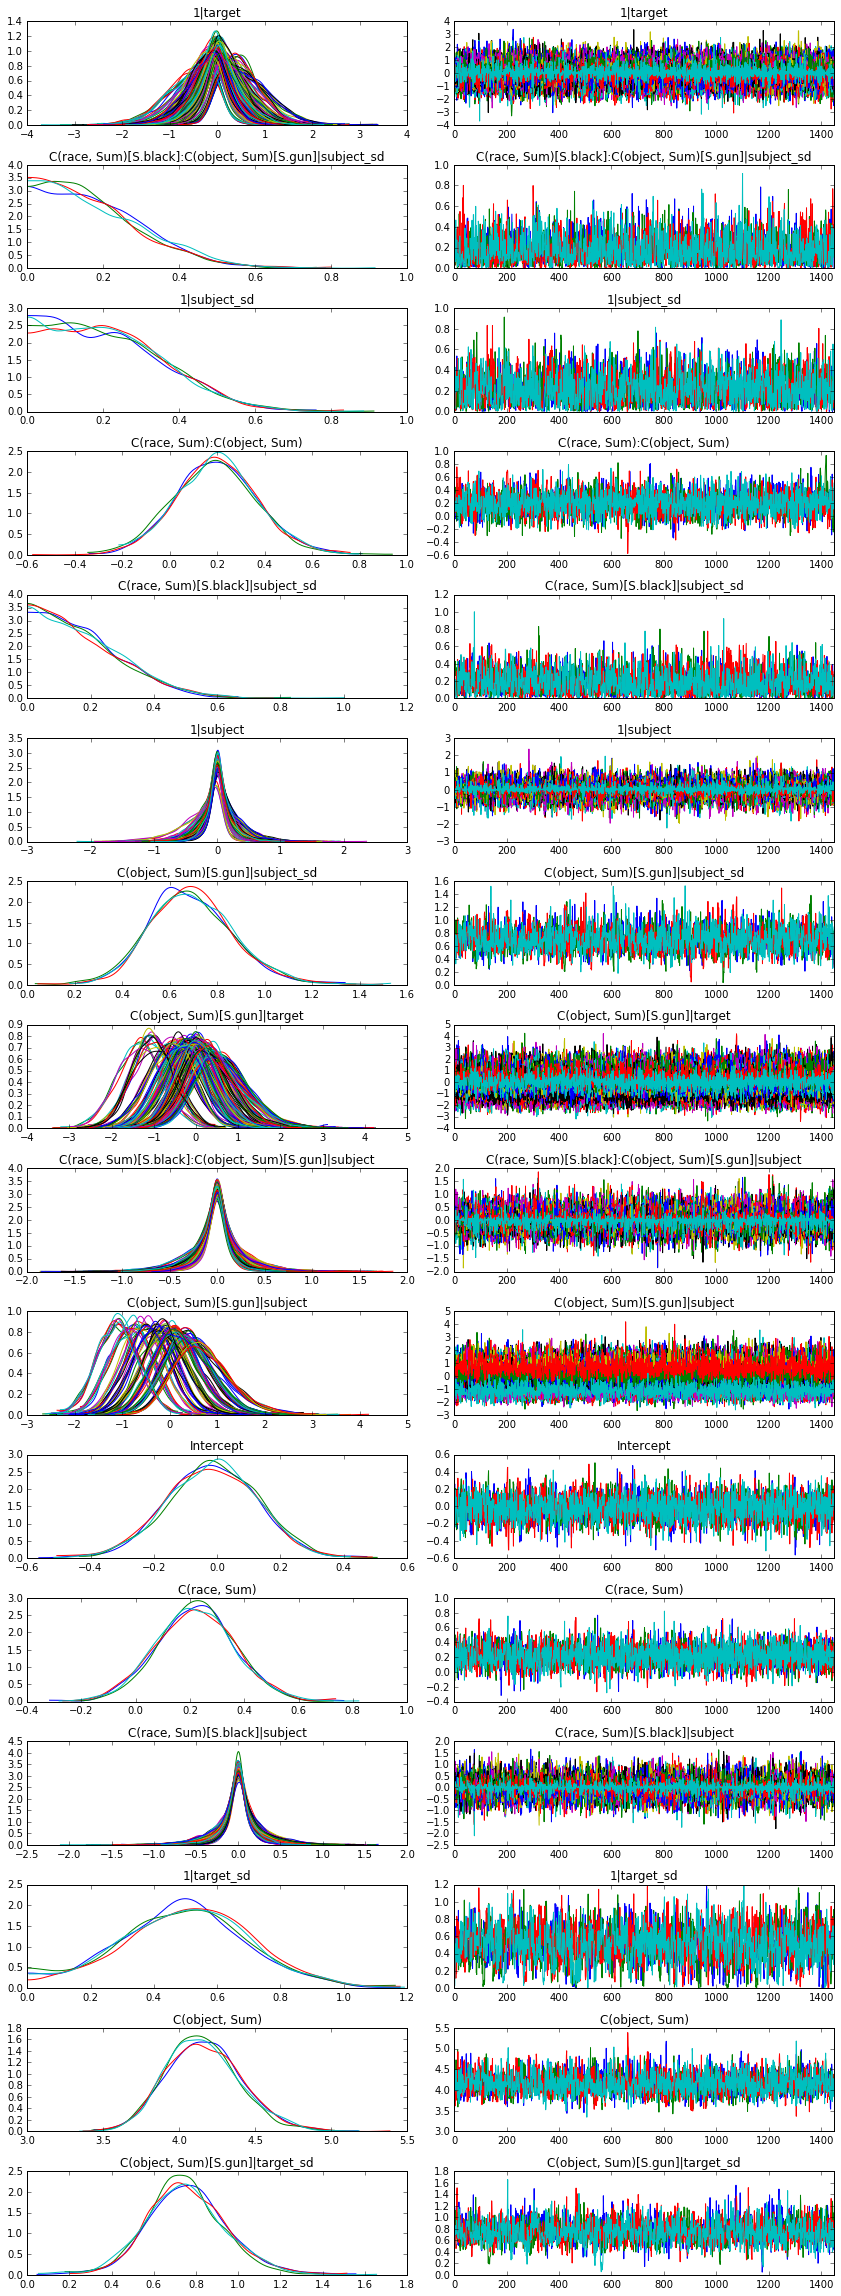

In [128]:
_ = stim_response_fitted[50:].plot()

Looks pretty good! Now for the more concise summary.

In [129]:
stim_response_fitted[50:].summary()

/Users/Jake/Desktop/Google Drive/bambi/bambi/results.py:351: UserWarning: Modeling the probability that shoot_or_not=='shoot'
  str(self.model.data[self.model.y.name][event])))


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
"C(race, Sum)[S.black]:C(object, Sum)[S.gun]|subject_sd",0.181917,0.133273,0.000079,0.431185,2592,1.000793
1|subject_sd,0.219976,0.147469,0.000632,0.486505,2049,1.000027
"C(race, Sum):C(object, Sum)",0.197223,0.173677,-0.153717,0.533533,3374,1.000438
"C(race, Sum)[S.black]|subject_sd",0.180289,0.134042,0.000396,0.431189,2726,1.000242
"C(object, Sum)[S.gun]|subject_sd",0.693249,0.179383,0.368624,1.069315,2111,1.000672
Intercept,-0.017385,0.143199,-0.285240,0.272906,4628,1.000453
"C(race, Sum)",0.221385,0.143827,-0.068302,0.495646,5124,0.999901
1|target_sd,0.496492,0.205158,0.011736,0.844490,1139,1.001503
"C(object, Sum)",4.160396,0.245555,3.710885,4.660650,2811,1.000469
"C(object, Sum)[S.gun]|target_sd",0.751620,0.187975,0.395377,1.134231,1393,1.002457


There is some slight evidence here for the hypothesis that subjects are more likely to shoot the black targets, regardless of whether they are armed or not, but the evidence is a little weak. The marginal posterior for the `C(race, Sum)` coefficient is mostly concentrated away from 0, but it overlaps even more in this case with 0 than did the key interaction effect in the previous model.

In [131]:
(stim_response_fitted['C(race, Sum)'].to_df() < 0).mean()

C(race, Sum)    0.0635
dtype: float64